In [5]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC

# Problem 1: Digit Recognizer

In [6]:
# Loading the dataset
dataset = np.load("dataset.npz")
X, y = dataset["X"], dataset["y"]

## Data exploration and pre-processing

In [7]:
# Print a random sample to visualise it
print(X[5].reshape(20,20))
print(y[5])

[[ 74  15  22  87  29  73  25  57  79  73  61  43   8  74  40  41  34  21
   58  31]
 [ 21  82  82  51  49  29  50  31   9   9   2   7   3  71  87  24  48  71
   18  64]
 [ 69  24  54  43  59  35  47  16  14  62 104 142  95  28   3   7   3  76
   45  22]
 [ 59  52  32  15  21  27  60   3  55 198 244 252 236 160  48   4  27  37
   25  23]
 [ 21   1  80  81  55  10  53  97 128 213 238 226 239 242 132  29  84  48
   25  32]
 [ 12  55  62  59   4  62 195 236 235 188 122  78 157 248 189  70   1  20
   42  38]
 [ 11  45  14  51   6  87 237 252 237 158  50  15 138 248 196  76   1  50
   23  84]
 [  2   6  55  73   3  57 200 243 156  63  45 111 222 247 153  38  70  72
    1  20]
 [  5  17  79  62  10   9 100 224 192 114 158 231 243 177  69  12  10  83
   50  10]
 [ 23  69  69  27  78   1  27 169 243 233 245 245 168  46   5  31  43  55
   27   0]
 [  5   6  60  28   1  16  87 211 254 254 251 196  55   3   7  22  50  64
   81  65]
 [ 20  32  40  16  13  89 214 250 247 238 242 204  67   3  89  22

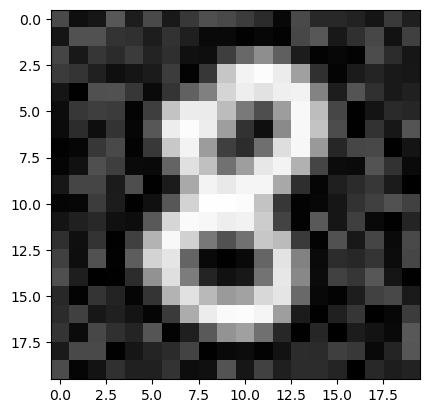

In [8]:
# Here we can see more clearly that it is a 8
plt.imshow(X[5].reshape(20,20), vmin=0, vmax=255.0, cmap="gray")
plt.show()

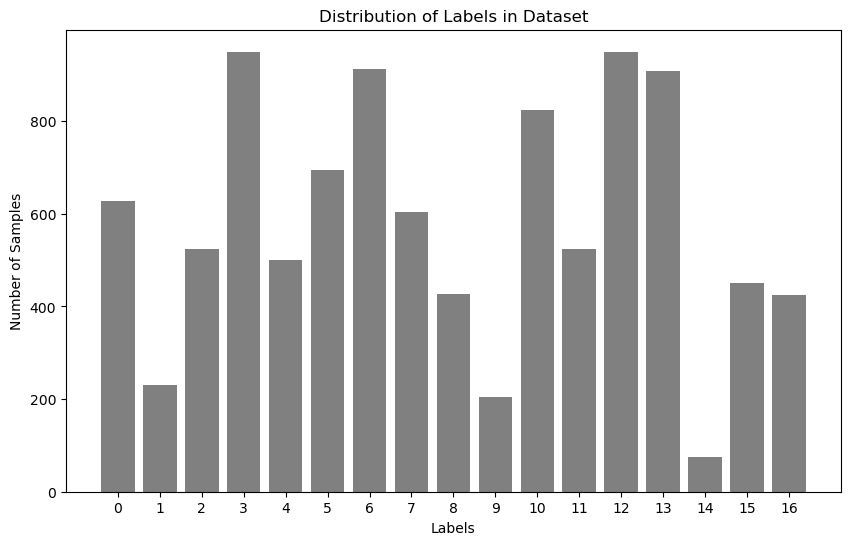

Highest count of classes:  950
Lowest count of classes:  74


In [9]:
# Visualizing the distribution of classes in the dataset
label_counts = Counter(y)
labels = list(label_counts.keys())
counts = list(label_counts.values())
sorted_labels_counts = sorted(zip(labels, counts), key=lambda x: x[0])
sorted_labels, sorted_counts = zip(*sorted_labels_counts)


plt.figure(figsize=(10, 6))
plt.bar(sorted_labels, sorted_counts, color='gray')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of Labels in Dataset')
plt.xticks(sorted_labels)  
plt.show()

print("Highest count of classes: ", max(label_counts.values()))
print("Lowest count of classes: ", min(label_counts.values()))


Above we see that the classes has very different amount of samples. Class 14 has only 74, and class 3 as as much as 950. This means that there is a imbalance in the dataset that we need to account for. Our approach will be to oversample our data so that we remove the imbalance.

The reason we chose to oversample is because this improves performance on minority classes.
We know that oversampling can lead to overfitting since we have more of the same data and with oversampling it increases computational cost for us to train and tune since it has more data to go through. But we think it is worth it, and we are choosing to use k-fold cross validation when we are tuning to account for overfitting risks.

In [10]:
# For reproducability
# Set seed 
seed = 0
np.random.seed(seed)

# For using k-fold cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=seed)

In [11]:
#Split the data into test and (training and validation)
X_train_val, X_test, y_train_val, y_test = train_test_split(X,y, test_size=0.3, random_state=seed, shuffle=True)

# We normalize so that whatever classifier we choose all features will contribute equally. (This is not needed for random forest, but it is for others.)
# Normalize the data to [0, 1] 
X_train_val = X_train_val / 255.0
X_test = X_test / 255.0

# Oversample with Smote
smote = SMOTE(random_state=seed)
X_train_val, y_train_val = smote.fit_resample(X_train_val, y_train_val)


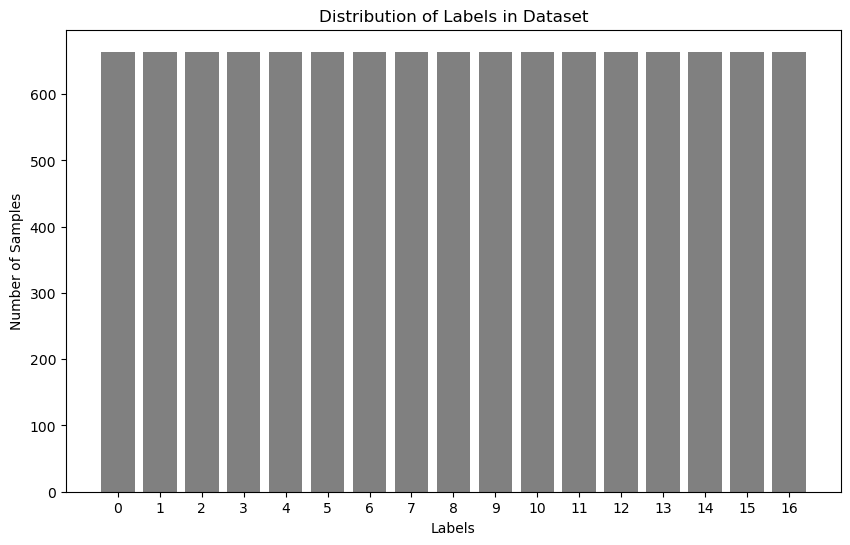

Highest count of classes:  664
Lowest count of classes:  664


In [12]:
# Visualizing the distribution of classes in the dataset now after oversampling
label_counts = Counter(y_train_val)
labels = list(label_counts.keys())
counts = list(label_counts.values())
sorted_labels_counts = sorted(zip(labels, counts), key=lambda x: x[0])
sorted_labels, sorted_counts = zip(*sorted_labels_counts)


plt.figure(figsize=(10, 6))
plt.bar(sorted_labels, sorted_counts, color='gray')
plt.xlabel('Labels')
plt.ylabel('Number of Samples')
plt.title('Distribution of Labels in Dataset')
plt.xticks(sorted_labels)  
plt.show()

print("Highest count of classes: ", max(label_counts.values()))
print("Lowest count of classes: ", min(label_counts.values()))

## After oversampling

We see that the distribution has no imbalance now after oversampling.

# Random Forest classifier

In [163]:
rf = RandomForestClassifier(random_state=seed)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [10,15,20,40,100],  # Number of trees in the forest
    'max_depth': [None, 10,15,20,30],  # Maximum depth of the trees
    'max_features': ['sqrt','log2'], # Number of features to consider for best split
    'criterion': ['entropy','gini']
}   

# Set up k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=kfold, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_train_val, y_train_val)

# Print the best hyperparameters and best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation accuracy:", grid_search.best_score_)

#Here we can use accruacy when tuning since we removed the imbalance

c:\Users\elias\anaconda3\envs\INF264\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 15, 'max_features': 'sqrt', 'n_estimators': 100}
Best Cross-Validation accuracy: 0.9448075135205775


In [166]:
# Testing the hyperparameters on test set
rf = RandomForestClassifier(n_estimators=grid_search.best_params_.get('n_estimators'), max_depth=grid_search.best_params_.get('max_depth'), criterion=grid_search.best_params_.get('criterion'), max_features=grid_search.best_params_.get('max_features'), random_state=seed)

rf.fit(X_train_val,y_train_val)

# Here we use classification report so that we can see how well the classifier performs on each class
print(classification_report(y_test, rf.predict(X_test)))


              precision    recall  f1-score   support

           0       0.81      0.90      0.85       184
           1       0.86      0.97      0.91        77
           2       0.91      0.79      0.84       151
           3       0.86      0.92      0.89       292
           4       0.82      0.92      0.87       142
           5       0.90      0.86      0.88       207
           6       0.94      0.92      0.93       248
           7       0.91      0.94      0.92       195
           8       0.86      0.74      0.80       129
           9       0.77      0.72      0.74        60
          10       0.85      0.93      0.88       242
          11       0.84      0.74      0.78       174
          12       0.91      0.95      0.93       303
          13       0.89      0.76      0.82       272
          14       0.88      0.64      0.74        22
          15       0.81      0.85      0.83       140
          16       1.00      1.00      1.00       113

    accuracy              

Above we see our results! # TODO

# SVM


In [169]:
svm = SVC(random_state = seed)

param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'rbf', 'poly'],  # Kernel type to be used in the algorithm
    'gamma': ['scale', 'auto'],  # Kernel coefficient
    'degree': [2, 3, 4]  # Degree of the polynomial kernel function ('poly')
}

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, 
                           scoring='accuracy',  
                           cv=kfold, n_jobs=-1, verbose=2)


grid_search.fit(X_train_val, y_train_val)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation accuracy:", grid_search.best_score_)



Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters: {'C': 10, 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf'}
Best Cross-Validation accuracy: 0.9692593027184788


In [172]:
# Evaluate the best model on the test set
best_svm = grid_search.best_estimator_

# Here we use classification report so that we can see how well the classifier performs on each class
print(classification_report(y_test, best_svm.predict(X_test)))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89       184
           1       0.89      1.00      0.94        77
           2       0.93      0.84      0.88       151
           3       0.96      0.95      0.95       292
           4       0.86      0.92      0.89       142
           5       0.93      0.90      0.91       207
           6       0.96      0.96      0.96       248
           7       0.92      0.95      0.94       195
           8       0.91      0.84      0.87       129
           9       0.94      0.77      0.84        60
          10       0.90      0.93      0.92       242
          11       0.88      0.86      0.87       174
          12       0.96      0.95      0.96       303
          13       0.86      0.91      0.89       272
          14       1.00      0.64      0.78        22
          15       0.85      0.91      0.88       140
          16       1.00      1.00      1.00       113

    accuracy              

# Problem 2:  Dimensionality Reduction

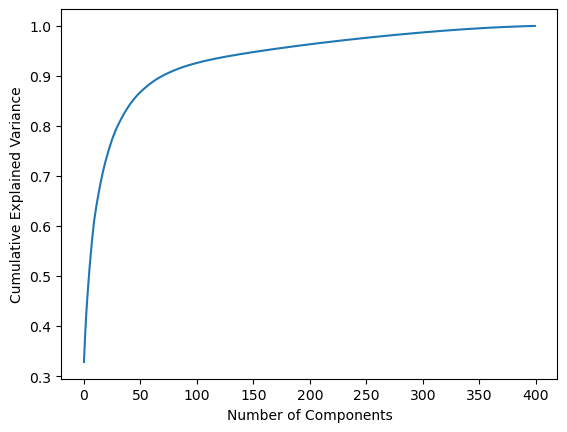

In [13]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_val)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()



In [15]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report
import pandas as pd

# List of n_components values to test
n_components_list = [10, 20]

# Define a structure to store the results
results = []

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [10, 15, 20, 40, 100],  # Number of trees in the forest
    'max_depth': [None, 10, 15, 20, 30],  # Maximum depth of the trees
    'max_features': ['sqrt', 'log2'],  # Number of features to consider for best split
    'criterion': ['entropy', 'gini']  # Splitting criterion
}

# Set up k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

for dimensions in n_components_list:
    print(f"\nTesting with {dimensions} components")

    # Perform PCA
    pca = PCA(n_components=dimensions, random_state=seed)
    X_train_val_pca = pca.fit_transform(X_train_val)
    X_test_pca = pca.transform(X_test)

    # Calculate total variance explained
    total_variance_explained = pca.explained_variance_ratio_.sum()
    print(f"Total variance explained with {dimensions} components: {total_variance_explained:.4f}")

    # Set up GridSearchCV with Random Forest
    rf = RandomForestClassifier(random_state=seed)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                               scoring='accuracy', 
                               cv=kfold, n_jobs=-1, verbose=0)
    
    # Fit the grid search to the data
    grid_search.fit(X_train_val_pca, y_train_val)
    
    # Get the best hyperparameters and cross-validation accuracy
    best_hyperparams = grid_search.best_params_
    best_cv_accuracy = grid_search.best_score_
    print("Best Hyperparameters:", best_hyperparams)
    print("Best Cross-Validation accuracy:", best_cv_accuracy)

    # Train the Random Forest model with best hyperparameters
    rf_best = RandomForestClassifier(n_estimators=best_hyperparams['n_estimators'],
                                     max_depth=best_hyperparams['max_depth'],
                                     criterion=best_hyperparams['criterion'],
                                     max_features=best_hyperparams['max_features'],
                                     random_state=seed)
    rf_best.fit(X_train_val_pca, y_train_val)

    # Generate the classification report on the test set
    test_predictions = rf_best.predict(X_test_pca)
    class_report = classification_report(y_test, test_predictions, output_dict=True)
    
    # Store the results in the results list
    results.append({
        'n_components': dimensions,
        'total_variance_explained': total_variance_explained,
        'best_hyperparameters': best_hyperparams,
        'best_cv_accuracy': best_cv_accuracy,
        'classification_report': class_report
    })

# Convert the results into a DataFrame for easier visualization
results_df = pd.DataFrame(results)

# Display the DataFrame
print(results_df)

# If you want to view the full classification report for each value, you can access it like this:
for i, row in results_df.iterrows():
    print(f"\nClassification Report for n_components={row['n_components']}:")
    print(pd.DataFrame(row['classification_report']))


Testing with 10 components
Total variance explained with 10 components: 0.6102
Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Best Cross-Validation accuracy: 0.8859840048851069

Testing with 20 components
Total variance explained with 20 components: 0.7287
Best Hyperparameters: {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}
Best Cross-Validation accuracy: 0.9312543634546276
   n_components  total_variance_explained  \
0            10                  0.610168   
1            20                  0.728673   

                                best_hyperparameters  best_cv_accuracy  \
0  {'criterion': 'gini', 'max_depth': None, 'max_...          0.885984   
1  {'criterion': 'gini', 'max_depth': 20, 'max_fe...          0.931254   

                               classification_report  
0  {'0': {'precision': 0.6736842105263158, 'recal...  
1  {'0': {'precision': 0.8043478260869565, 'recal...  


In [208]:
n_components_list = [10,20,50,100,200,300]

results = []



# Perform PCA 
pca = PCA(n_components=dimensions, random_state=seed)

X_train_val_pca = pca.fit_transform(X_train_val) # prøve bare transform
X_test_pca = pca.transform(X_test)


# Look at this:
print(f"Total variance explained with {dimensions} components: {pca.explained_variance_ratio_.sum()}")


Total variance explained with 100 components: 0.9254948611719924


In [201]:
rf = RandomForestClassifier(random_state=seed)

# Define the hyperparameters to tune
param_grid = {
    'n_estimators': [10,15,20,40,100],  # Number of trees in the forest
    'max_depth': [None, 10,15,20,30],  # Maximum depth of the trees
    'max_features': ['sqrt','log2'], # Number of features to consider for best split
    'criterion': ['entropy','gini']
}   

# Set up k-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=seed)

# Set up GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           scoring='accuracy', 
                           cv=kfold, n_jobs=-1, verbose=0)

# Fit the grid search to the data
grid_search.fit(X_train_val_pca, y_train_val)

# Print the best hyperparameters and best score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation accuracy:", grid_search.best_score_)

c:\Users\elias\anaconda3\envs\INF264\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Hyperparameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 100}
Best Cross-Validation accuracy: 0.9337343165814612


In [202]:
# Testing the hyperparameters on test set
rf = RandomForestClassifier(n_estimators=grid_search.best_params_.get('n_estimators'), max_depth=grid_search.best_params_.get('max_depth'), criterion=grid_search.best_params_.get('criterion'), max_features=grid_search.best_params_.get('max_features'), random_state=seed)

rf.fit(X_train_val_pca,y_train_val)

# Here we use classification report so that we can see how well the classifier performs on each class
print(classification_report(y_test, rf.predict(X_test_pca)))


              precision    recall  f1-score   support

           0       0.77      0.82      0.80       184
           1       0.88      0.95      0.91        77
           2       0.88      0.74      0.80       151
           3       0.85      0.91      0.88       292
           4       0.83      0.84      0.83       142
           5       0.88      0.83      0.85       207
           6       0.88      0.90      0.89       248
           7       0.88      0.92      0.90       195
           8       0.86      0.72      0.78       129
           9       0.78      0.67      0.72        60
          10       0.82      0.91      0.86       242
          11       0.75      0.67      0.71       174
          12       0.85      0.92      0.88       303
          13       0.83      0.76      0.80       272
          14       0.67      0.36      0.47        22
          15       0.76      0.80      0.78       140
          16       1.00      1.00      1.00       113

    accuracy              